# Classifying Fashion-MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src='assets/fashion-mnist-sprite.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebooks though as you work through this.

First off, let's load the dataset through torchvision.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import torchvision.transforms as T
import helper
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

transform = T.Compose([ T.ToTensor(), 
                        T.Normalize((0.5,),(0.5,)) ])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)


Extracting /home/testuser/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/testuser/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /home/testuser/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/testuser/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /home/testuser/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/testuser/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /home/testuser/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/testuser/.pytorch/F_MNIST_data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


0 T-shirt/top  
1 Trouser  
2 Pullover  
3 Dress  
4 Coat  
5 Sandal  
6 Shirt  
7 Sneaker  
8 Bag  
9 Ankle boot  

In [2]:
image, label = next(iter(trainloader))

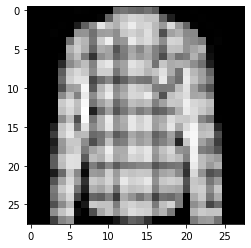

In [3]:
plt.imshow(image[0,:].permute(1,2,0).squeeze().numpy(), cmap='Greys_r');

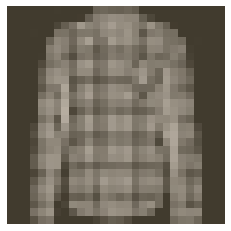

In [4]:
helper.imshow(image[0,:]);

Here we can see one of the images.

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits or log-softmax from the forward pass. It's up to you how many layers you add and the size of those layers.

In [5]:
# TODO: Define your network architecture here

class fmnist(nn.Module):
    def __init__(self, layers, n_input=784, n_classes = 10, dropout_prob=0):
        
        def fmnist_block(f_in, f_out, dropout_prob=0):
            return nn.Sequential(*[nn.Dropout(p=dropout_prob), nn.Linear(f_in, f_out), nn.ReLU()])
        
        super().__init__()
        self.dropout_prob = dropout_prob
        #add first and last dimensions
        layers.insert(0, n_input)
        layers.append(n_classes)
        
        net = [fmnist_block(layers[i-1], layers[i], dropout_prob=self.dropout_prob) for i in range(1, len(layers))]
        self.net = nn.Sequential(*net)
                         
    def forward(self, x):
        return F.log_softmax(self.net(x.view(x.shape[0],-1)), dim=1)  

In [16]:
# TODO: Define your network architecture here

class fmnist_listed(nn.Module):
    def __init__(self, layers, n_input=784, n_classes = 10, dropout_prob=0):
        
        def fmnist_block(f_in, f_out, dropout_prob=0):
            return [nn.Dropout(p=dropout_prob), nn.Linear(f_in, f_out), nn.ReLU()]
        
        super().__init__()
        self.dropout_prob = dropout_prob
        #add first and last dimensions
        layers.insert(0, n_input)
        layers.append(n_classes)
        self.net = nn.ModuleList()
        
        for f_in, f_out in zip(layers[:-1], layers[1:]):
            self.net.extend(fmnist_block(f_in, f_out, self.dropout_prob))
                             
    def forward(self, x):
        out = x.view(x.shape[0],-1)
        for layer in self.net:
            out = layer(out)
        return F.log_softmax(out, dim=1)  

criterion = nn.NLLLoss()

In [17]:
#net = fmnist([128,64,32])
#net = fmnist([256,128,64], dropout_prob=0.5)
net = fmnist_listed([256,128,64], dropout_prob=0.5)

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
display(device)
#device = 'cpu'
net.to(device);

'cuda:0'

In [22]:
image.shape

torch.Size([64, 1, 28, 28])

In [19]:
image.view(64,-1).shape

torch.Size([64, 784])

In [20]:
# sanity check
with torch.no_grad():
    out = net(image.to(device))
torch.exp(out).sum()

tensor(64., device='cuda:0')

In [23]:
out.shape

torch.Size([64, 10])

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [37]:
# TODO: Create the network, define the criterion and optimizer
# done before

In [24]:
def init_weights(m):
    """
    initialize weights with Kaming 
    https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
    """
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        #torch.nn.init.kaiming_normal_(m.bias)
net.apply(init_weights);

## Requires Grad block

In [ ]:
net.net[0][0].weight.requires_grad=False
net.net[0][0].bias.requires_grad=False
net.net[0][0].weight.requires_grad, net.net[0][0].bias.requires_grad

In [25]:
def check_grads(n):
    '''
    check if all submodules have requires grads
    '''
    if isinstance(n, nn.Linear):
        print(n)
        for name, par in n.named_parameters():
            print(name, par.requires_grad)
        print('---')

In [26]:
net.apply(check_grads)

Linear(in_features=784, out_features=256, bias=True)
weight True
bias True
---
Linear(in_features=256, out_features=128, bias=True)
weight True
bias True
---
Linear(in_features=128, out_features=64, bias=True)
weight True
bias True
---
Linear(in_features=64, out_features=10, bias=True)
weight True
bias True
---


fmnist_listed(
  (net): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=64, out_features=10, bias=True)
    (11): ReLU()
  )
)

In [80]:
net.requires_grad_(True)
net.apply(check_grads)

Linear(in_features=784, out_features=256, bias=True)
weight True
bias True
---
Linear(in_features=256, out_features=128, bias=True)
weight True
bias True
---
Linear(in_features=128, out_features=64, bias=True)
weight True
bias True
---
Linear(in_features=64, out_features=10, bias=True)
weight True
bias True
---


fmnist(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=10, bias=True)
      (1): ReLU()
    )
  )
)

In [81]:
net.net[0].requires_grad_(False)
net.apply(check_grads)

Linear(in_features=784, out_features=256, bias=True)
weight False
bias False
---
Linear(in_features=256, out_features=128, bias=True)
weight True
bias True
---
Linear(in_features=128, out_features=64, bias=True)
weight True
bias True
---
Linear(in_features=64, out_features=10, bias=True)
weight True
bias True
---


fmnist(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=10, bias=True)
      (1): ReLU()
    )
  )
)

In [27]:
%%time
# TODO: Train the network here
N_EPOCH = 30

# return back to requires grad
net.requires_grad_(True);

# create an optimizer
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
net.train()
net.to(device)

train_loss = []
test_loss = []
for epoch in tqdm(range(N_EPOCH)):
    running_loss = 0
    net.train()
    for data, labels in trainloader:
        optimizer.zero_grad()
        out = net(data.to(device))
        loss_item = criterion(out, labels.to(device))
        loss_item.backward()
        optimizer.step()
        running_loss +=loss_item.item()
    train_loss.append(running_loss/len(trainloader))
    print(f'Epoch {epoch}, loss = {train_loss[-1]}')
    
    
    net.eval()
    with torch.no_grad():
        # don't need a loop cos all in one batch
        data, labels = next(iter(testloader))
        ps = net(data.to(device))
        test_loss.append(criterion(ps, labels.to(device)))
        ps = torch.exp(ps)
        _, predicted_classes = ps.max(dim=1)
        predicted_classes = predicted_classes.to('cpu')
        accuracy_score = sum(predicted_classes == labels).item()/len(labels)

Epoch 0, loss = 1.4048190828897298
Epoch 1, loss = 0.8482615954713273
Epoch 2, loss = 0.7613793932107974
Epoch 3, loss = 0.7173524464307818
Epoch 4, loss = 0.6937250371998561
Epoch 5, loss = 0.6618035814718906
Epoch 6, loss = 0.6429053473192999
Epoch 7, loss = 0.6360181961486588
Epoch 8, loss = 0.6258048155605157
Epoch 9, loss = 0.615583145637502
Epoch 10, loss = 0.6119526306639856
Epoch 11, loss = 0.5982606523136086
Epoch 12, loss = 0.5940270219911644
Epoch 13, loss = 0.5873031550124764
Epoch 14, loss = 0.5854067704570827
Epoch 15, loss = 0.5770609924661071
Epoch 16, loss = 0.5764497048946332
Epoch 17, loss = 0.5726941622841333
Epoch 18, loss = 0.5689635866804164
Epoch 19, loss = 0.5681720946325677
Epoch 20, loss = 0.567217193083214
Epoch 21, loss = 0.5618433960910036
Epoch 22, loss = 0.5590123097334844
Epoch 23, loss = 0.5634720226817294
Epoch 24, loss = 0.560838850068131
Epoch 25, loss = 0.5535537617356538
Epoch 26, loss = 0.5568045254455192
Epoch 27, loss = 0.5515233077474241
Epoch

Accuracy score for the network is 0.8508


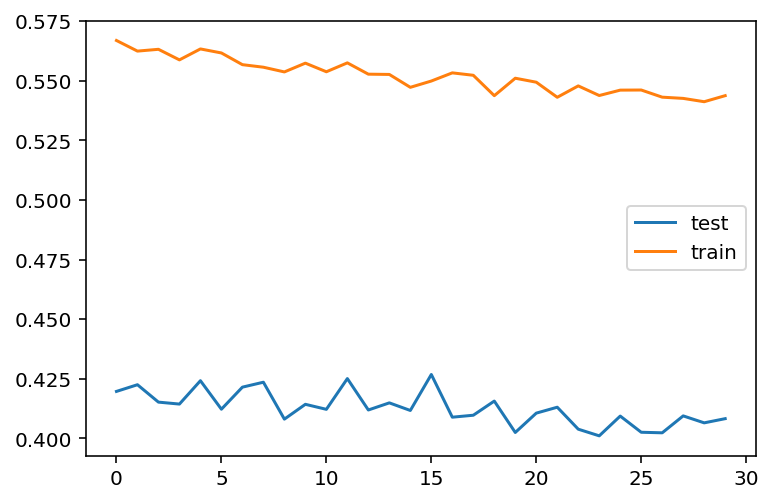

In [92]:
plt.plot(list(range(N_EPOCH)), test_loss, label='test')
plt.plot(list(range(N_EPOCH)), train_loss, label='train')
plt.legend(loc='best')
print(f'Accuracy score for the network is {accuracy_score}')
plt.show()

### Calculate the accuracy 

In [93]:
with torch.no_grad():
    net.to(device)
    data, labels = next(iter(testloader))
    predictions = torch.exp(net(data.to(device)))

top_p, top_class = predictions.topk(1,dim=1)
equals = top_class == labels.view(top_class.shape).to(device)
accuracy_score = torch.mean(equals.type(torch.FloatTensor)).item()
print(f'accuracy score = {accuracy_score:.2f}')

accuracy score = 0.85


In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
for i in range(len(trainset.classes)):
    print(f'{trainset.classes[i]:>11} : precision = {precision_score(predicted_classes==i, labels==i):.2f} \
recall = {recall_score(predicted_classes==i, labels==i):.2f}')

T-shirt/top : precision = 0.90 recall = 0.72
    Trouser : precision = 0.96 recall = 1.00
   Pullover : precision = 0.71 recall = 0.80
      Dress : precision = 0.87 recall = 0.87
       Coat : precision = 0.88 recall = 0.68
     Sandal : precision = 0.92 recall = 0.97
      Shirt : precision = 0.44 recall = 0.73
    Sneaker : precision = 0.91 recall = 0.91
        Bag : precision = 0.96 recall = 0.97
 Ankle boot : precision = 0.97 recall = 0.91


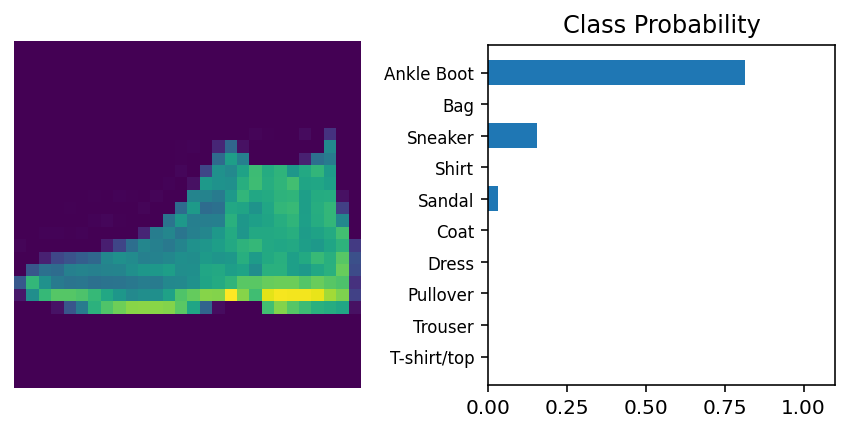

In [95]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# TODO: Calculate the class probabilities (softmax) for img
net.eval()
with torch.no_grad():
    ps = torch.exp(net(img.to(device)))

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps.to('cpu'), version='Fashion')